In [9]:
from tensorflow.keras import layers, optimizers, losses, metrics, activations, regularizers, callbacks
from keras.models import Model
import numpy as np
import pandas as pd
import shap

In [2]:


x_train = np.load('xtrain.npy')
y_train = np.load('ytrain.npy', allow_pickle=True)
x_test  = np.load('xtest.npy')
y_test  = np.load('ytest.npy', allow_pickle=True)
print(x_train.shape)
x_train = x_train.transpose(0, 2, 1)            # transpose working correctly
x_test  = x_test.transpose(0, 2, 1)
print(x_train.shape)
x_train = x_train.reshape(19601, 12, 1000, 1)   # Add another channel
x_test  = x_test.reshape(2198, 12, 1000, 1)

print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)
print('Data loaded')

(19601, 1000, 12)
(19601, 12, 1000)
x_train : (19601, 12, 1000, 1)
y_train : (19601,)
x_test  : (2198, 12, 1000, 1)
y_test  : (2198,)
Data loaded


In [3]:
from sklearn.preprocessing import MultiLabelBinarizer


# Convert multi-label target labels to one-hot encoded matrix
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
print("Classes:", mlb.classes_)

Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']


In [4]:
from tensorflow.keras.models import load_model
model = load_model('ST-CNN-GAP-5.h5')

In [5]:
import os
from tensorflow.keras.models import load_model
import numpy as np


classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarcation', 'Normal ECG', 'ST/T change']


''' Load a sample file '''
x = np.loadtxt("hyp_2690.csv", delimiter=",")
x = x.transpose(1, 0)                              # transpose matrix
x = np.expand_dims(x, axis=(0, -1))                # Add another channel on left and right


''' Load Model '''



''' Evaluate Model '''
y_prob = model.predict(x)

print("Sample belongs to following classes:")
for i in range(5):
    if y_prob[0][i] >= 0.5 :
        print(" * " + classes[i])

1/1 [==============================] - 4s 4s/step
Sample belongs to following classes:
 * Hypertrophy
 * ST/T change


In [6]:
shap_values = np.load('shap_values.npy')
shap_values.shape

(5, 5, 12, 1000, 1)

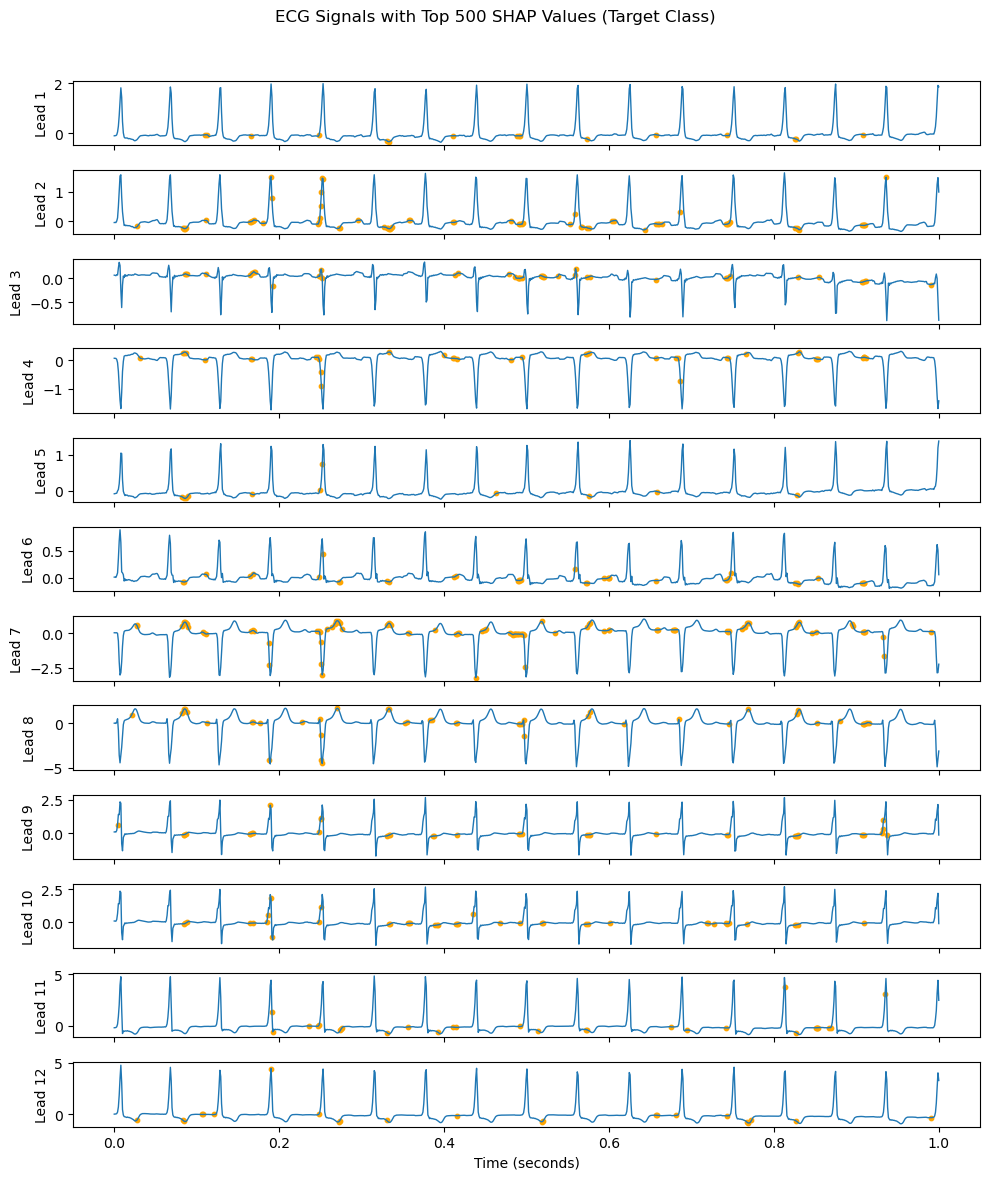

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 12, 1000, 1]

ecg_data = x
batch_size, num_leads, signal_length, _ = ecg_data.shape

# Sample SHAP values with dimensions [batch size, 5, 12, 1000, 1]

shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 1  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[0, target_class_idx, :, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.unravel_index(np.argsort(np.abs(target_shap_values).ravel())[-500:], target_shap_values.shape)

# Create a time array
sampling_rate = 1000  # Replace with your actual sampling rate
time = np.linspace(0, signal_length / sampling_rate, signal_length)

# Create subplots for each lead
fig, axes = plt.subplots(num_leads, 1, figsize=(10, 12), sharex=True)

# Plot each lead with overlay of SHAP values for the target class
for lead_idx in range(num_leads):
    lead_data = ecg_data[0, lead_idx, :, 0]
    axes[lead_idx].plot(time, lead_data, lw=1, label=f'Lead {lead_idx + 1}')
    top_shap_indices = np.where(top_indices[0] == lead_idx)[0]
    top_shap_values = target_shap_values[lead_idx, top_indices[1][top_shap_indices]]

    # Scale the SHAP values to the range of ECG data for better visualization
    scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)
    
    # Highlight corresponding ECG signal points with orange color
    axes[lead_idx].scatter(time[top_indices[1][top_shap_indices]], lead_data[top_indices[1][top_shap_indices]], color='orange', s=10)
    axes[lead_idx].set_ylabel(f'Lead {lead_idx + 1}')

axes[num_leads - 1].set_xlabel('Time (seconds)')
plt.suptitle('ECG Signals with Top 500 SHAP Values (Target Class)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

